# EDA of the RADgraph data 
## Objective: Perform exploratory data analysis (EDA) on the RadGraph dataset.
## Tasks: Inspect dataset schema, visualize entity and relation distributions, and examine sample annotations.


## Data Loading
The dataset consists of:
- **Findings JSON**: Detailed findings from radiology reports.
- **Impressions JSON**: High-level diagnostic impressions, summarizing findings.

In [1]:
import json
from datasets import load_from_disk
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd
import config
from radgraph.data.preprocess import prepare_dataset
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch")

# Load the dataset
dataset = load_from_disk(f"../{config.PROCESSED_DATA_DIR}")  # Adjust path if necessary
print(f"Total reports: {len(dataset)}")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Total reports: 281097


## Dataset Summary
This section summarizes the overall structure of the dataset, including:
- **Text Length**: Average length of the reports.
- **Entity Counts**: Number of annotated entities per report.
- **Relation Counts**: Number of relationships between entities per report.

In [2]:

def summarize_schema(dataset):
    """
    Summarizes the schema of the RadGraph dataset.
    Args:
        dataset (Dataset): Hugging Face Dataset object.
    Returns:
        pd.DataFrame: Summary of the schema.
    """
    schema_summary = []
    for example in dataset:
        text_length = len(example["text"])
        num_entities = len(example["labels"])
        num_relations = sum(len(label.get("relations", [])) for label in example["labels"])

        schema_summary.append({
            "Text Length": text_length,
            "Num Entities": num_entities,
            "Num Relations": num_relations,
        })

    return pd.DataFrame(schema_summary)


# Assuming the dataset is prepared using your `prepare_dataset` function:
json_files = [f"../{config.SECTION_FINDINGS_FILE}", f"../{config.SECTION_IMPRESSION_FILE}"]
dataset = prepare_dataset(json_files)

# Generate schema summary
schema_df = summarize_schema(dataset)

# Save the summary to CSV (optional)
schema_df.to_csv("schema_summary.csv", index=False)

# Display first few rows of the schema summary
print(schema_df.head())


   Text Length  Num Entities  Num Relations
0          460            30             23
1          460            30             23
2          400            26             16
3          401            28             20
4          401            28             20


## Visualizing Dataset Distributions
Plot distributions of text lengths and entity counts.
Text length and entity counts follow similar distributions, suggesting a potential correlation. Reports with higher verbosity are likely to include more annotated entities.

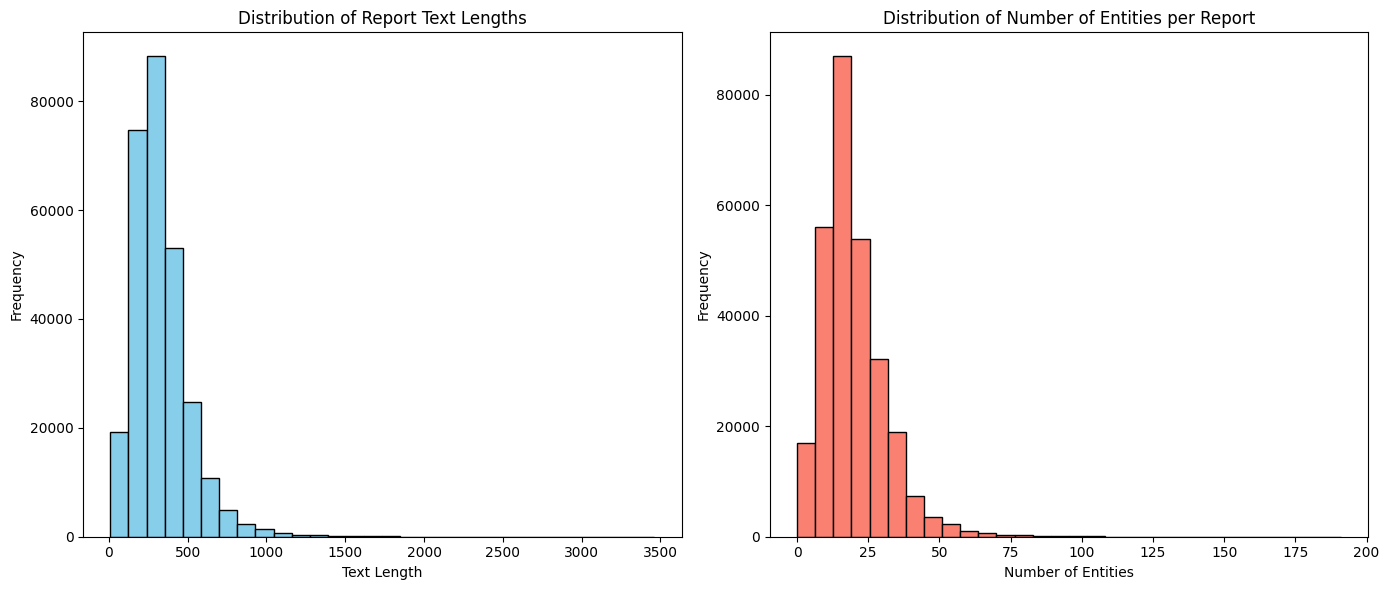

In [3]:
# Visualize Text Length and Entity Count Distributions
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Text Length Distribution
axs[0].hist(schema_df['Text Length'], bins=30, color='skyblue', edgecolor='black')
axs[0].set_title("Distribution of Report Text Lengths")
axs[0].set_xlabel("Text Length")
axs[0].set_ylabel("Frequency")

# Entity Count Distribution
axs[1].hist(schema_df['Num Entities'], bins=30, color='salmon', edgecolor='black')
axs[1].set_title("Distribution of Number of Entities per Report")
axs[1].set_xlabel("Number of Entities")
axs[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Entity Counts:
#### Dominant Entity Types:

- Anatomy::definitely present: 2,456,763 occurrences.
- Observation::definitely present: 2,440,911 occurrences.
- These dominant entity types reflect that most annotations focus on present anatomical features and observations, likely describing findings visible in the radiology images.
#### Rare Entity Types:

- Anatomy::measurement::definitely present: 14,307 occurrences.
- This entity type captures specific measurements, such as dimensions or numerical observations, which are relatively rare compared to general anatomical observations.
#### Uncertain Observations and Measurements:

- Uncertainty (Observation::uncertain, Anatomy::uncertain) appears less frequently, reflecting lower annotation focus on ambiguous cases.
### Relation Counts:
#### Dominant Relation Types:

- modify: 2,298,287 occurrences.
    - Indicates frequent connections where an entity (e.g., an adjective like "increased") modifies another (e.g., "opacity").
- located_at: 1,377,917 occurrences.
     - Suggests detailed localization of findings (e.g., a condition associated with a specific anatomical location).
#### Less Common Relation Types:

- suggestive_of: 202,792 occurrences.
    - Captures speculative relationships, such as a finding suggesting a potential diagnosis, which are less frequent but clinically important.

## Entity and Relation Analysis
Extract and display annotated examples.

In [4]:
def extract_entity_relation_stats(dataset):
    from collections import Counter
    entity_counts = Counter()
    relation_counts = Counter()

    for example in dataset:
        # print(example.keys())  # Debugging: Check keys in example
        for entity in example["labels"]:  # Iterate through the list of entities
            entity_counts[entity["label"]] += 1  # Access the 'label' of each entity
            for relation in entity.get("relations", []):  # Iterate through the 'relations' list
                relation_counts[relation[0]] += 1
    return entity_counts, relation_counts

# Use the function
entity_counts, relation_counts = extract_entity_relation_stats(dataset)
print("Entity Counts:", entity_counts)
print("Relation Counts:", relation_counts)


Entity Counts: Counter({'Anatomy::definitely present': 2456763, 'Observation::definitely present': 2440911, 'Observation::definitely absent': 396044, 'Observation::uncertain': 265709, 'Anatomy::measurement::definitely present': 14307, 'Observation::measurement::definitely present': 6393, 'Anatomy::uncertain': 1018, 'Anatomy::definitely absent': 254, 'Observation::measurement::uncertain': 22, 'Observation::measurement::definitely absent': 1})
Relation Counts: Counter({'modify': 2298287, 'located_at': 1377917, 'suggestive_of': 202792})


## Annotated Report Examples
Extract and display annotated examples.

In [13]:
def extract_examples(dataset, num_examples=3):
    """
    Extracts examples with entities and relations from the dataset.
    Args:
        dataset (Dataset): Hugging Face Dataset object.
        num_examples (int): Number of examples to extract.
    Returns:
        List[dict]: List of selected examples with entities and relations.
    """
    examples = []
    for example in dataset:
        entities = example["labels"]
        if len(entities) > 2:  # Choose reports with enough entities
            relations = sum(len(label["relations"]) for label in entities)
            if relations:  # Ensure at least one relation exists
                examples.append({
                    "Text": example["text"],
                    "Entities": entities,
                })
        if len(examples) >= num_examples:
            break
    return examples


# Extract key examples
selected_examples = extract_examples(dataset, num_examples=2)

# Display the examples
for idx, example in enumerate(selected_examples):
    print(f"Example {idx + 1}")
    print(f"Text: {example['Text']}")
    print(f"Entities: {example['Entities']}\n")


Example 1
Text: Unchanged position of the left upper extremity PICC line . Again seen are surgical clips projecting over the right hemithorax . The cardiomediastinal silhouette is stable in appearance . Increased stranding opacities are noted in the left retrocardiac region . Subtle stranding opacities in the right upper lung zone are unchanged .. There are no pleural or significant bony abnormalities . Absence of the right breast shadow compatible with prior mastectomy .
Entities: [{'end_ix': 0, 'label': 'Observation::definitely present', 'relations': [['modify', '6']], 'start_ix': 0, 'tokens': 'Unchanged'}, {'end_ix': 1, 'label': 'Observation::definitely present', 'relations': [['modify', '1']], 'start_ix': 1, 'tokens': 'position'}, {'end_ix': 4, 'label': 'Anatomy::definitely present', 'relations': [['modify', '5']], 'start_ix': 4, 'tokens': 'left'}, {'end_ix': 5, 'label': 'Anatomy::definitely present', 'relations': [['modify', '5']], 'start_ix': 5, 'tokens': 'upper'}, {'end_ix': 6, 

## Visualizing annotations
- recap:
    - `Anatomy::definitely present` is used for anatomical observations
    - `Observation::definitely present` is for disease observed
    - `Observation::definitely absent` stating a disease is NOT there

### Challenges with Spacy Visualization and Entity Alignment

During the exploratory data analysis, I used SpaCy's displacy.render functionality to visualize entities and their labels within the text. However, aligning the annotated entity indices (start_ix and end_ix) with the raw text presented several challenges:

1. Misaligned Indices:

- The start_ix and end_ix values in the dataset sometimes did not correctly slice the corresponding entity from the raw text. This misalignment led to unexpected outputs such as partial or empty entities.
2. Ambiguities in Entity Definitions:

- Compound terms like "right lung base" were challenging to handle, as the dataset treats terms like "right" as modifiers of the main anatomical entity "lung." This hierarchical structure complicated index alignment.
3. Visualization Limitations:

- Despite debugging efforts, some entity slices (e.g., Entity: 'U' -> Label: Observation::definitely present) did not correctly match the intended spans. This issue was traced to discrepancies in how indices were generated during annotation.
4. Tokenization and Character Offsets:

- If the indices were based on tokens rather than raw text characters, additional preprocessing would be required to map token-based offsets to character-based offsets.


In [22]:

from spacy import displacy

def prepare_displacy_data(example):
    ents = []
    for entity in example["Entities"]:
        # Adjust indices to include the full span
        start = entity["start_ix"]
        end = entity["end_ix"] + 1
        # Extract and validate the entity text
        entity_text = example["Text"][start:end]
        # print(f"Entity: '{entity_text}' -> Label: {entity['label']}")  # Debugging
        ents.append({
            "start": start,
            "end": end,
            "label": entity["label"]
        })
    return {"text": example["Text"], "ents": ents, "title": None}



# Validate and render example
selected_examples = extract_examples(dataset, num_examples=3)
displacy_data = prepare_displacy_data(selected_examples[0])

colors = {
    "Observation::definitely present": "blue",
    "Observation::definitely absent": "red",
    "Anatomy::definitely present": "green",
}

options = {"colors": colors}
displacy.render(displacy_data, style="ent", manual=True, jupyter=True, options=options)
# for ent in displacy_data["ents"]:
#     print(f"Entity: {displacy_data['text'][ent['start']:ent['end']]} -> Label: {ent['label']}")
#     entity_text = example["Text"][entity["start_ix"]:entity["end_ix"] + 1]
#     print(f"Entity: '{entity_text}' -> Label: {entity['label']}")


# for i, example in enumerate(selected_examples[:3]):
#     displacy_data = prepare_displacy_data(example)
#     print(f"Example {i+1}")
#     displacy.render(displacy_data, style="ent", manual=True, jupyter=True)


# print(displacy_data)  # Validate structure
# displacy.render(displacy_data, style="ent", manual=True, jupyter=True)


## Visualizing Annotations
Highlight entities in text.


Highlighted Entities in Text:
There is redemonstration of right internal jugular central (Anatomy::definitely present) venous (Anatomy::definitely present) line (Observation::definitely present) , right (Anatomy::definitely present) internal (Anatomy::definitely present) jugular (Anatomy::definitely present) sheath (Observation::definitely present) , two (Observation::definitely present) mediastinal (Anatomy::definitely present) drains (Observation::definitely present) , sternotomy (Observation::definitely present) wires (Observation::definitely present) , and mediastinal (Anatomy::definitely present) surgical (Observation::definitely present) clips (Observation::definitely present) . Lung (Anatomy::definitely present) volumes (Anatomy::definitely present) have increased (Observation::definitely present) compared with the prior examination . There is decreased (Observation::definitely present) pulmonary (Anatomy::definitely present) edema (Observation::definitely present) and decrease

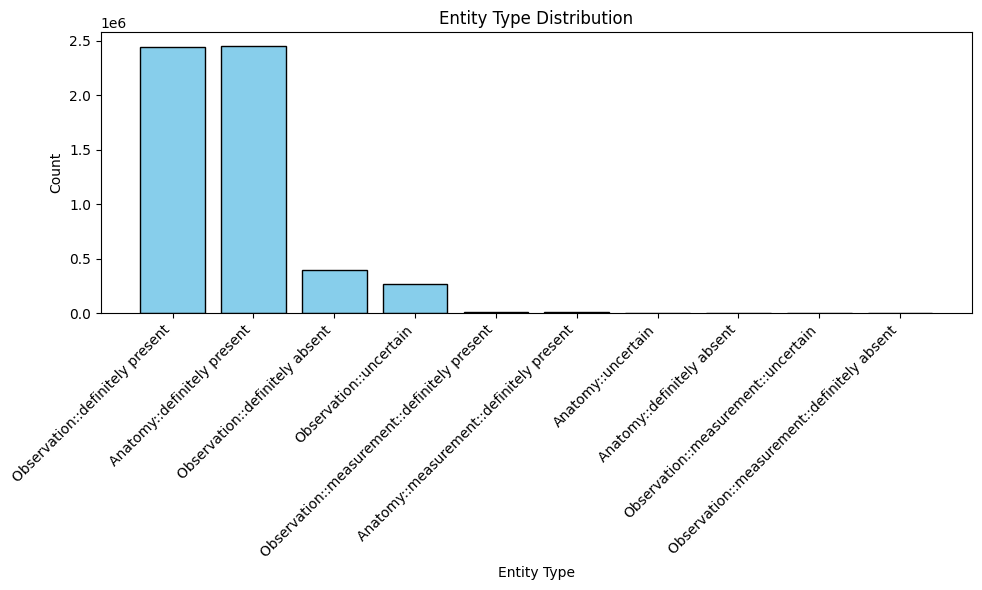

In [ ]:
from termcolor import colored

def highlight_entities(text, labels):
    """
    Highlights entities in the text.
    """
    words = text.split()
    for label in labels:
        start_ix, end_ix, label_text = label["start_ix"], label["end_ix"], label["label"]
        for i in range(start_ix, end_ix + 1):
            words[i] = colored(words[i], "cyan", attrs=["bold"]) + f" ({label_text})"
    return " ".join(words)

highlighted_text = highlight_entities(example["Text"], example["Entities"])


print("\nHighlighted Entities in Text:")
print(highlighted_text)
plt.figure(figsize=(10, 6))
plt.bar(entity_counter.keys(), entity_counter.values(), color="skyblue", edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.title("Entity Type Distribution")
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("entity_distribution.png")
plt.show()

## High-Level Stats

### Entity Distribution

Bar chart to visualize the frequency of each entity type.
This helps to see whether the dataset is balanced or skewed.


Entity Counts:
Observation::definitely present: 2440911
Anatomy::definitely present: 2456763
Observation::definitely absent: 396044
Observation::uncertain: 265709
Observation::measurement::definitely present: 6393
Anatomy::measurement::definitely present: 14307
Anatomy::uncertain: 1018
Anatomy::definitely absent: 254
Observation::measurement::uncertain: 22
Observation::measurement::definitely absent: 1


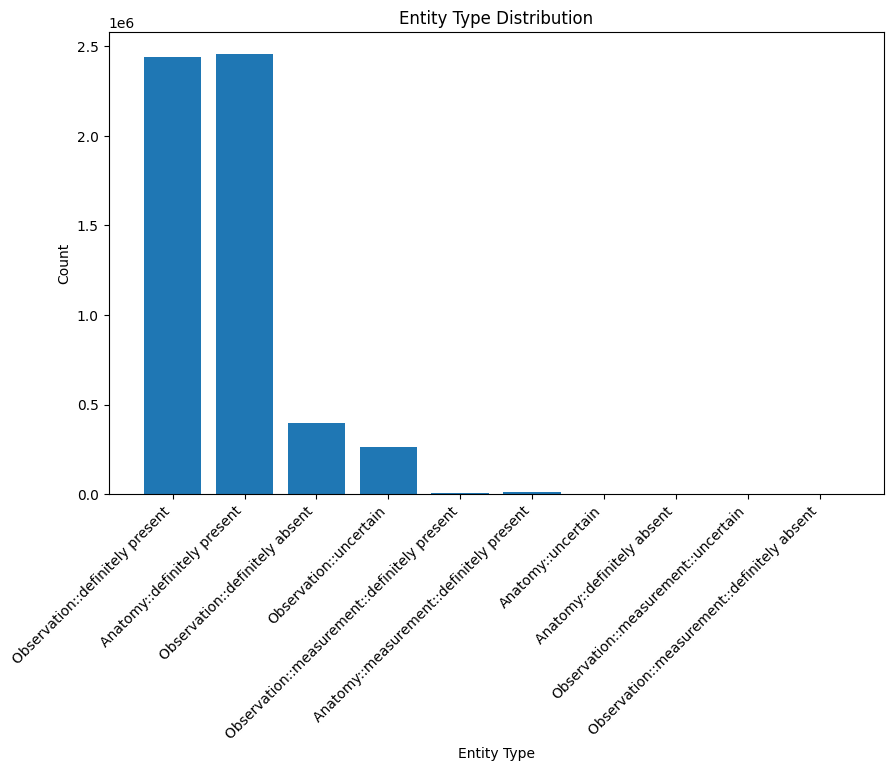

In [ ]:
# Count entities by type
entity_counter = Counter()
for report in dataset:
    for label in report["labels"]:
        entity_counter[label["label"]] += 1

# Display entity counts
print("Entity Counts:")
for entity, count in entity_counter.items():
    print(f"{entity}: {count}")

# Plot entity distribution
plt.figure(figsize=(10, 6))
plt.bar(entity_counter.keys(), entity_counter.values())
plt.xticks(rotation=45, ha="right")
plt.title("Entity Type Distribution")
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.show()


- The dataset is heavily skewed towards `Observation::definitely present` and `Anatomy::definitely present`.
- This skew might require careful handling in training (e.g., class weighting or data augmentation).


Average tokens per report: 56.26


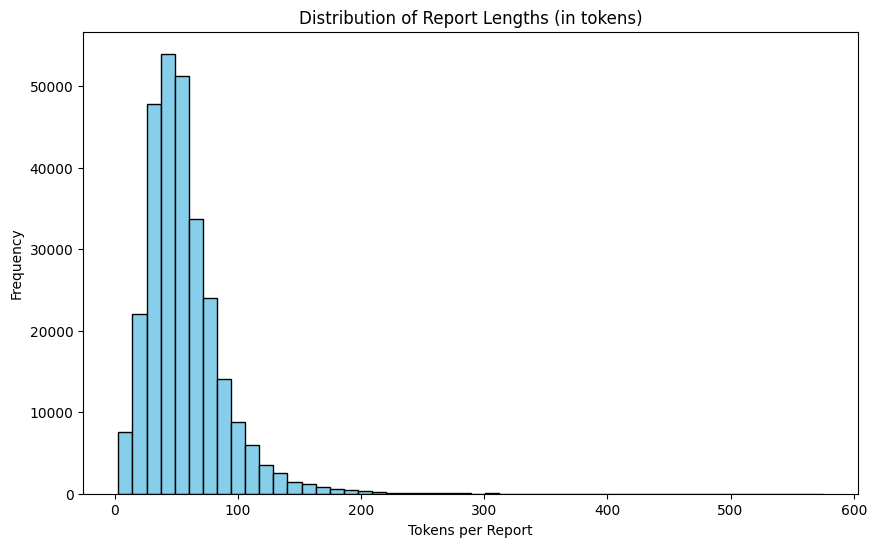

Average tokens per report: 56.26
Median tokens per report: 50.00
Max tokens per report: 575
Min tokens per report: 3


In [ ]:
# Average tokens per report
total_tokens = 0
for report in dataset:
    total_tokens += len(report["text"].split())

avg_tokens = total_tokens / len(dataset)
print(f"Average tokens per report: {avg_tokens:.2f}")

# Calculate tokens per report
report_lengths = [len(report["text"].split()) for report in dataset]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(report_lengths, bins=config.TOKEN_LENGTH_HIST_BINS, color="skyblue", edgecolor="black")
plt.title("Distribution of Report Lengths (in tokens)")
plt.xlabel("Tokens per Report")
plt.ylabel("Frequency")
plt.show()

import numpy as np

# Summary statistics for report lengths
print(f"Average tokens per report: {np.mean(report_lengths):.2f}")
print(f"Median tokens per report: {np.median(report_lengths):.2f}")
print(f"Max tokens per report: {np.max(report_lengths)}")
print(f"Min tokens per report: {np.min(report_lengths)}")



In [ ]:
# Find shortest and longest reports
shortest_report = min(dataset, key=lambda x: len(x["text"].split()))
longest_report = max(dataset, key=lambda x: len(x["text"].split()))

# Print shortest report
print("Shortest Report:")
print(f"Text: {shortest_report['text']}")
print("\nEntities:")
for label in shortest_report["labels"]:
    print(f"  Token: {label['tokens']}, Label: {label['label']}")

# Print longest report
print("\nLongest Report:")
print(f"Text: {longest_report['text']}")
print("\nEntities:")
for label in longest_report["labels"][:15]: #show first 15
    print(f"  Token: {label['tokens']}, Label: {label['label']}")


Shortest Report:
Text: See Impression .

Entities:

Longest Report:
Text: Initial single supine view of the chest on the trauma board , which obscures fine details , demonstrates low lung volumes . Motion artifact from breathing limits fine detail . The costophrenic angles are sharp . The cardiomediastinal silhouette is unremarkable . The pulmonary vessels are unremarkable . No dense focal pulmonary opacities are seen . A non - displaced mid - clavicular fracture is seen on the left . Subsequent single upright view of the chest demonstrates inferior displacement of the distal left clavicular fragment by approximately 1 shaft width . The lung volumes remain low , with mild bibasilar atelectasis . The costophrenic angles are sharp , without evidence of effusion . Normal cardiomediastinal silhouette . The pulmonary vessels are normal . No large focal consolidation is seen . There is no evidence for pneumothorax . Two views of the right knee demonstrate no fractures or dislocation . Overly

This plot examines the relationship between report verbosity and the frequency of a specific entity type (Observation::measurement::definitely present). Spikes suggest specific types of reports with numerous measurements.

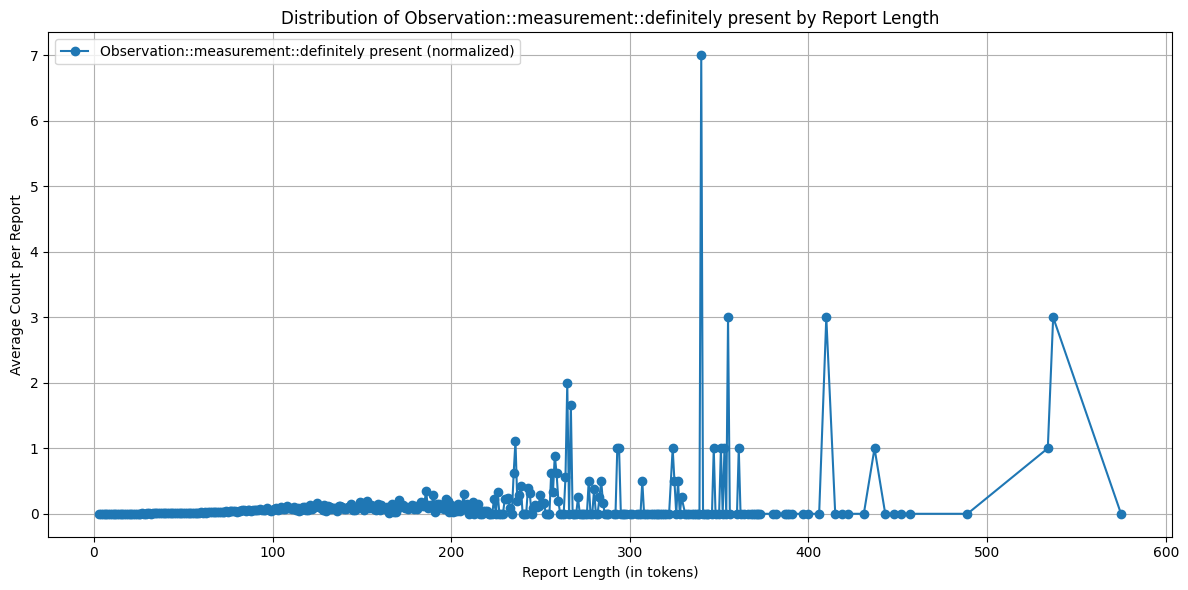

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Calculate report lengths (in tokens) and associate them with entity types
report_lengths = [len(report["text"].split()) for report in dataset]

entity_counts_by_length = defaultdict(lambda: defaultdict(int))

# Populate counts of each entity type by report length
for report, length in zip(dataset, report_lengths):
    for label in report["labels"]:
        entity_type = label["label"]
        entity_counts_by_length[length][entity_type] += 1

# Analyze trends for a specific entity type, e.g., 'Observation::measurement::definitely present'
entity_type = "Observation::measurement::definitely present"
lengths, counts = zip(*[(length, entity_counts_by_length[length][entity_type]) for length in sorted(entity_counts_by_length.keys())])

# Normalize counts by total reports of that length
report_counts_by_length = defaultdict(int)
for length in report_lengths:
    report_counts_by_length[length] += 1

normalized_counts = [count / report_counts_by_length[length] for length, count in zip(lengths, counts)]

# Plot the trends
plt.figure(figsize=(12, 6))
plt.plot(lengths, normalized_counts, marker='o', label=f"{entity_type} (normalized)")
plt.title(f"Distribution of {entity_type} by Report Length")
plt.xlabel("Report Length (in tokens)")
plt.ylabel("Average Count per Report")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Conclusion
#### Counts
- Findings section: 57,805 reports
- Impression section: 223,292 reports
- Total: 281,097

#### Entity types include:
- Anatomical structures
- Medical observations (present/absent/uncertain)
- Measurements
- Class imbalance in the entity distribution

Relation types:
- Spatial relationships (located_at)
- Modifications (modify)
- Clinical implications (suggestive_of)
